[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv8 Object Detection on a Custom Dataset

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/wuZtUMEiKWY)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

Ultralytics YOLOv8 is a popular version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## Disclaimer

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the accompanying [Blog Post](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/).

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv8
- CLI Basics
- Inference with Pre-trained COCO Model
- Roboflow Universe
- Preparing a custom dataset
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Dec 25 21:41:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [3]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

# prevent ultralytics from tracking your activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.6/112.6 GB disk)


In [4]:
###########################################
!pip -q uninstall -y numpy ultralytics opencv-python opencv-python-headless
!pip -q install --no-cache-dir "numpy<2" opencv-python-headless ultralytics

import numpy as np
import ultralytics
print("numpy:", np.__version__)
print("ultralytics:", ultralytics.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 311.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 320.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 397.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 184.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.1.48 requires opencv-python-headless==4.10.0.84, but you have opencv-python-headless 4.11.0.86 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy

In [5]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [6]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/content
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 49.0ms
Speed: 2.6ms preprocess, 49.0ms inference, 17.1ms postprocess per image at shape (1, 3, 640, 384)
Results saved to /content/runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


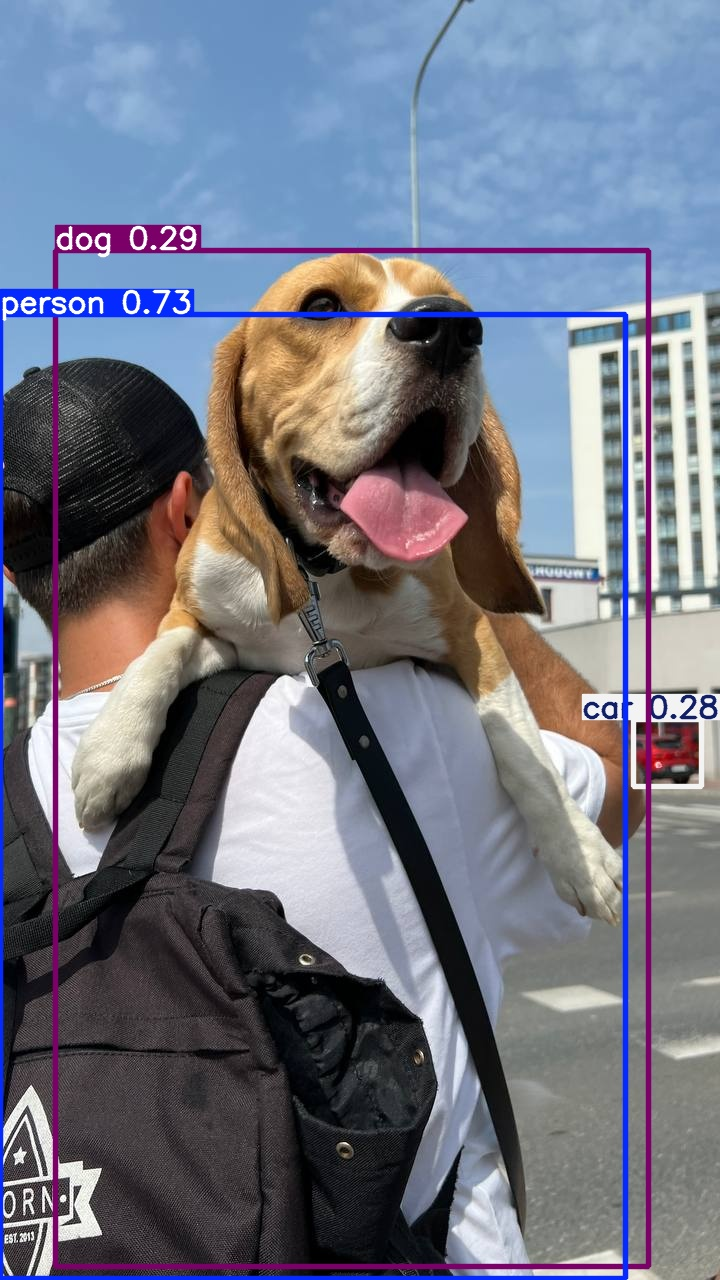

In [7]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

### 🐍 Python SDK

The simplest way of simply using YOLOv8 directly in a Python environment.

In [8]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 49.4ms
Speed: 1.9ms preprocess, 49.4ms inference, 15.9ms postprocess per image at shape (1, 3, 640, 384)


In [9]:
results[0].boxes.xyxy

tensor([[   0.0000,  314.4716,  625.0754, 1278.1947],
        [  55.1731,  250.0220,  648.1080, 1266.2720],
        [ 633.2291,  719.5391,  701.0538,  786.0336]], device='cuda:0')

In [10]:
results[0].boxes.conf

tensor([0.7271, 0.2907, 0.2846], device='cuda:0')

In [11]:
results[0].boxes.cls

tensor([ 0., 16.,  2.], device='cuda:0')

## Roboflow Universe

Need data for your project? Before spending time on annotating, check out Roboflow Universe, a repository of more than 110,000 open-source datasets that you can use in your projects. You'll find datasets containing everything from annotated cracks in concrete to plant images with disease annotations.


[![Roboflow Universe](https://media.roboflow.com/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)



## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a [supported format](https://roboflow.com/formats), the Roboflow dashboard will automatically read the images and annotations together.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v8` dataset format. (Formerly, we used to use `Yolov5`, as the gif shows)

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>




🟢 Tip: The examples below work even if you use our non-custom model. However, you won't be able to deploy it to Roboflow. To do that, create a custom dataset as described below or fork (copy) one into your workspace from Universe.

In [15]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow==1.1.48 --quiet

import roboflow

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("model-examples").project("football-players-obj-detection")
dataset = project.version(2).download("yolov8")

/content/datasets
visit https://app.roboflow.com/auth-cli to get your authentication token.


KeyboardInterrupt: Interrupted by user

In [12]:
##############################################
# --- Remplacement Roboflow (SANS login) : download dataset YOLO + dataset.location compatible ---

import os, shutil, zipfile
from types import SimpleNamespace

# Base fixe (indépendant de %cd)
BASE = "/content"
DATASETS_DIR = os.path.join(BASE, "datasets")
os.makedirs(DATASETS_DIR, exist_ok=True)

DATASET_NAME = "african-wildlife"
DATASET_URL  = "https://github.com/ultralytics/assets/releases/download/v0.0.0/african-wildlife.zip"

zip_path = os.path.join(DATASETS_DIR, f"{DATASET_NAME}.zip")
dst = os.path.join(DATASETS_DIR, DATASET_NAME)

# 1) Download (pas d'auth)
!wget -q -O "{zip_path}" "{DATASET_URL}"

# 2) Extraction propre
shutil.rmtree(dst, ignore_errors=True)
os.makedirs(dst, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(dst)

# 3) Si le zip contient un dossier racine (ex: african-wildlife/...), on se place dedans
inner = os.path.join(dst, DATASET_NAME)
if os.path.isdir(inner) and os.path.isdir(os.path.join(inner, "images")):
    dst = inner

# 4) Vérifs structure attendue
assert os.path.isdir(os.path.join(dst, "images", "train")), "images/train manquant"
assert os.path.isdir(os.path.join(dst, "images", "val")),   "images/val manquant"
assert os.path.isdir(os.path.join(dst, "labels", "train")), "labels/train manquant"
assert os.path.isdir(os.path.join(dst, "labels", "val")),   "labels/val manquant"

# 5) data.yaml (4 classes)
yaml_path = os.path.join(dst, "data.yaml")
names = ["buffalo", "elephant", "rhino", "zebra"]

with open(yaml_path, "w") as f:
    f.write(f"path: {dst}\n")
    f.write("train: images/train\n")
    f.write("val: images/val\n")
    f.write("test: images/test\n")
    f.write("names:\n")
    for i, n in enumerate(names):
        f.write(f"  {i}: {n}\n")

# 6) Objet dataset compatible "dataset.location"
dataset = SimpleNamespace(location=dst)

print("dataset.location =", dataset.location)
print("data.yaml =", os.path.join(dataset.location, "data.yaml"))
print("images subdirs =", os.listdir(os.path.join(dataset.location, "images")))
print("labels subdirs =", os.listdir(os.path.join(dataset.location, "labels")))

dataset.location = /content/datasets/african-wildlife
data.yaml = /content/datasets/african-wildlife/data.yaml
images subdirs = ['train', 'val', 'test']
labels subdirs = ['train', 'val', 'test']


## Custom Training

In [13]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

/content
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/african-wildlife/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

/content


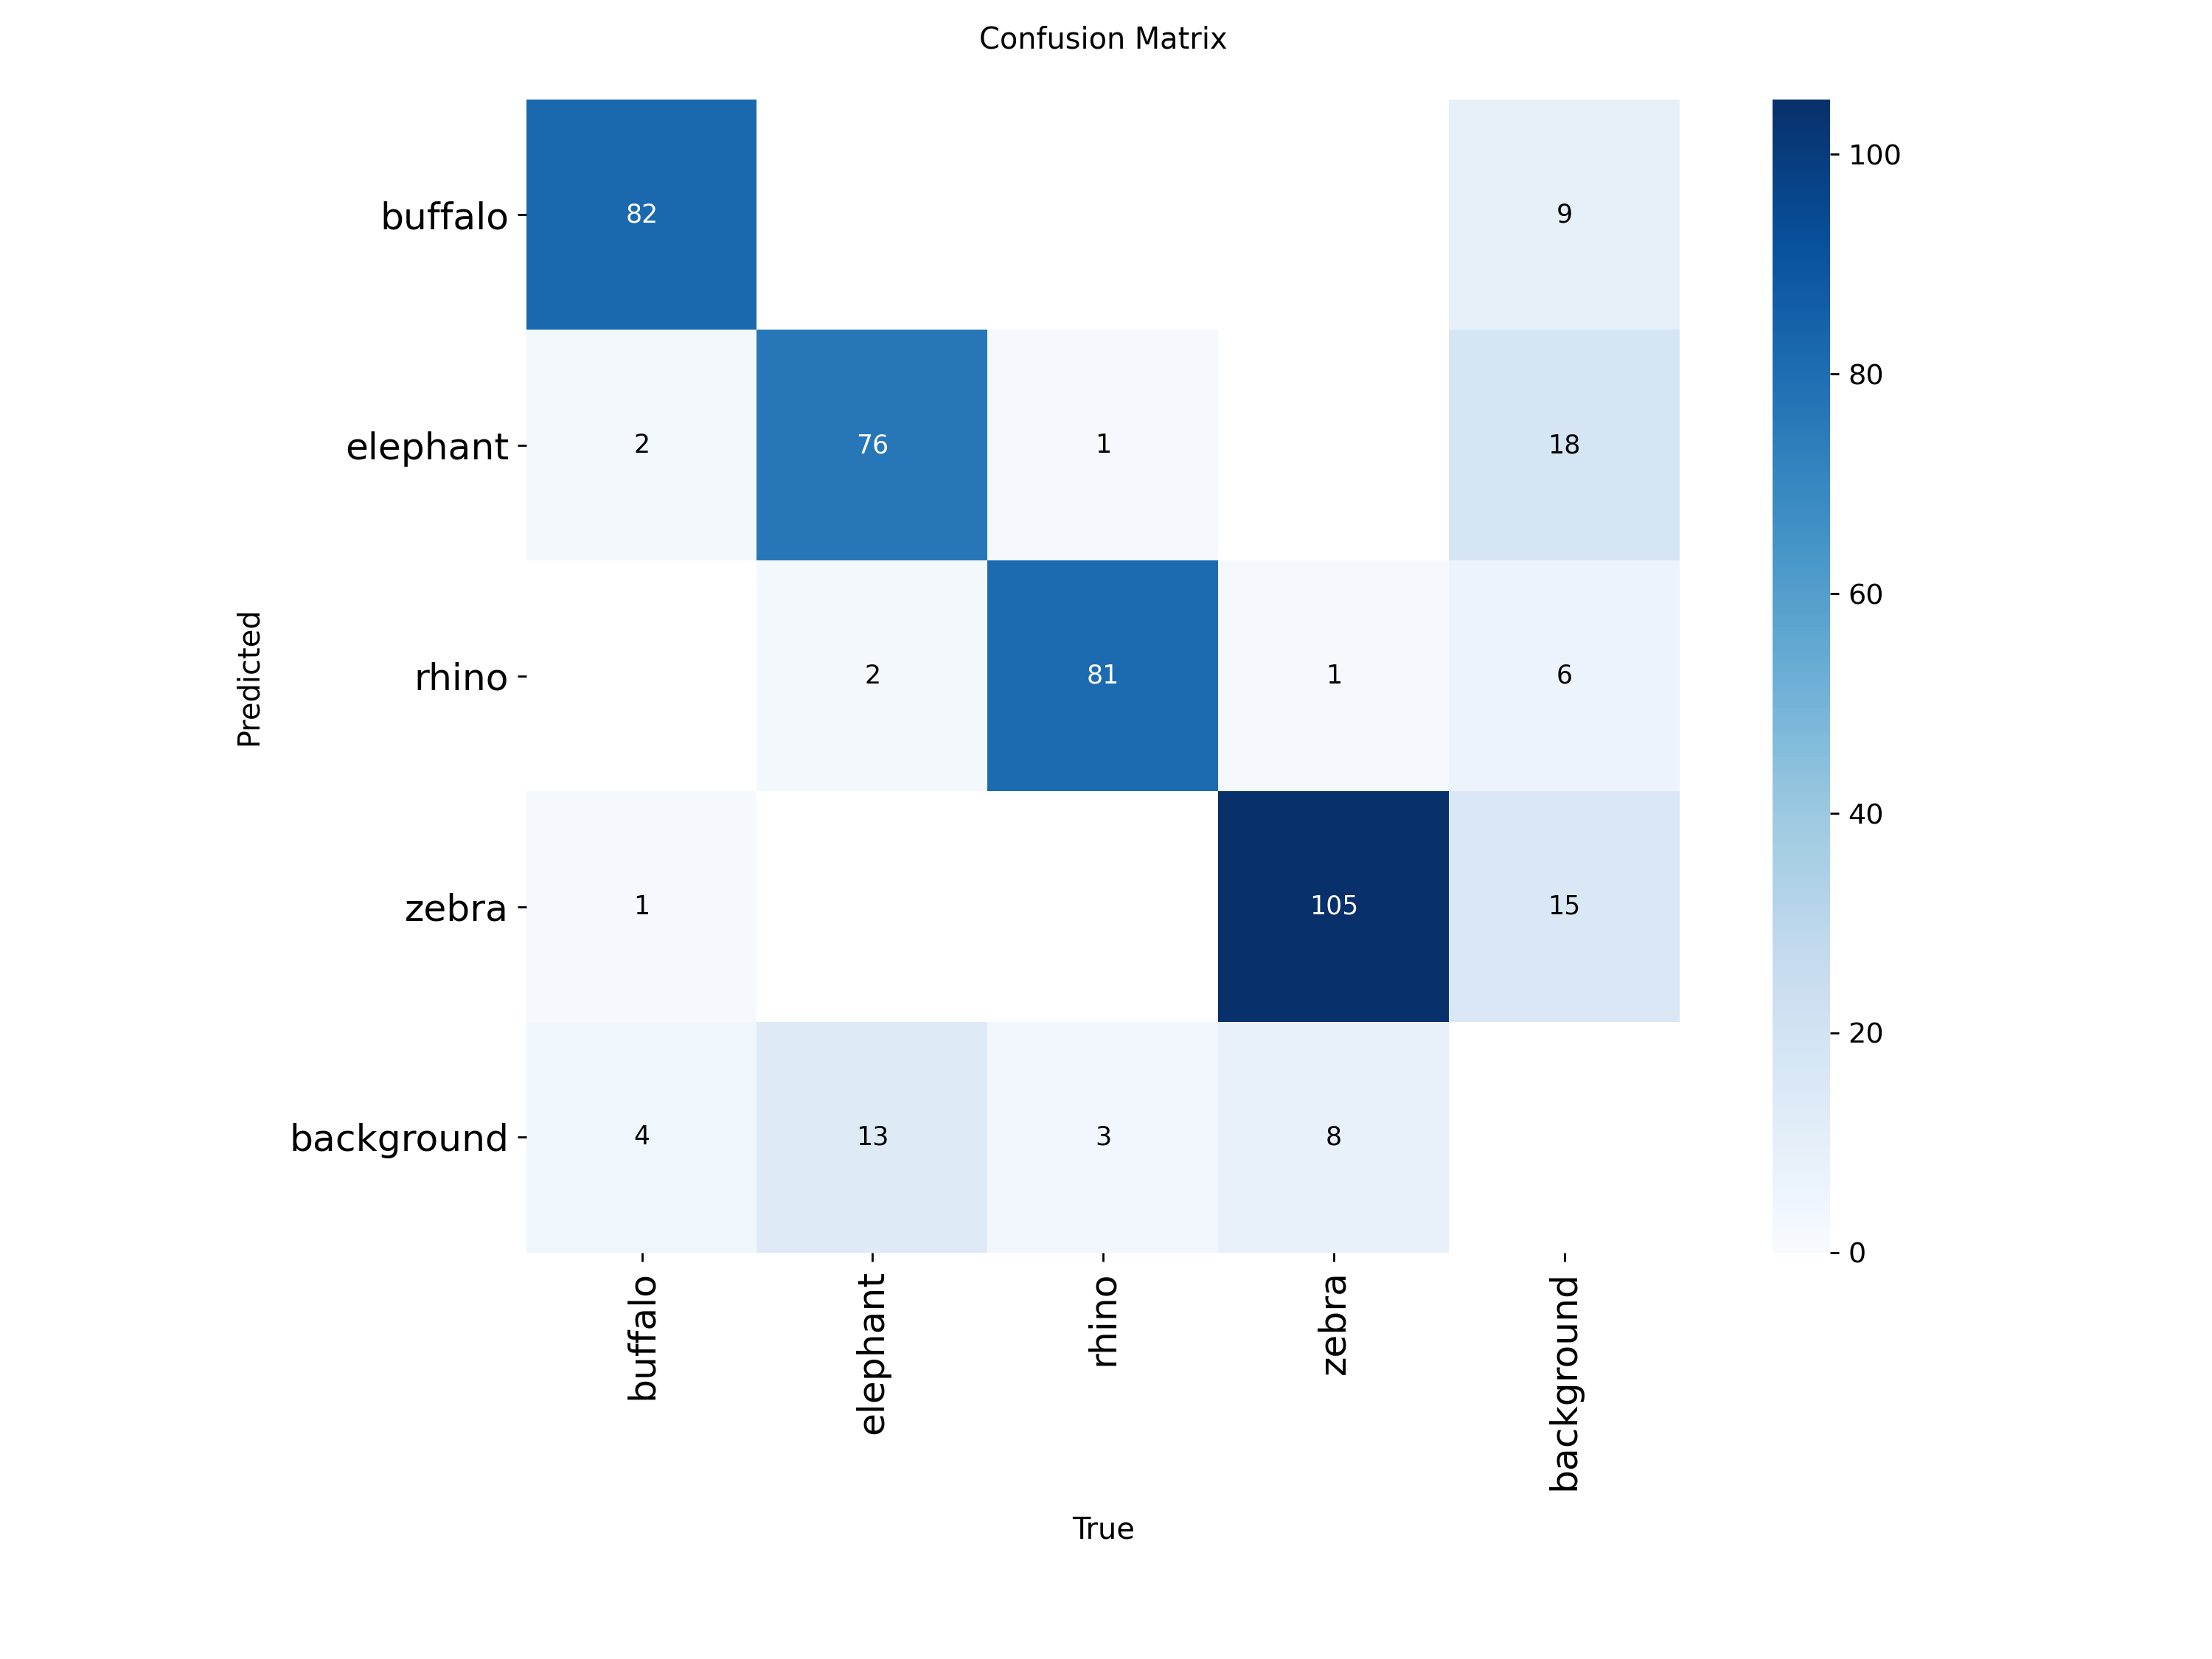

In [15]:
##################### remplace train par train2
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

/content


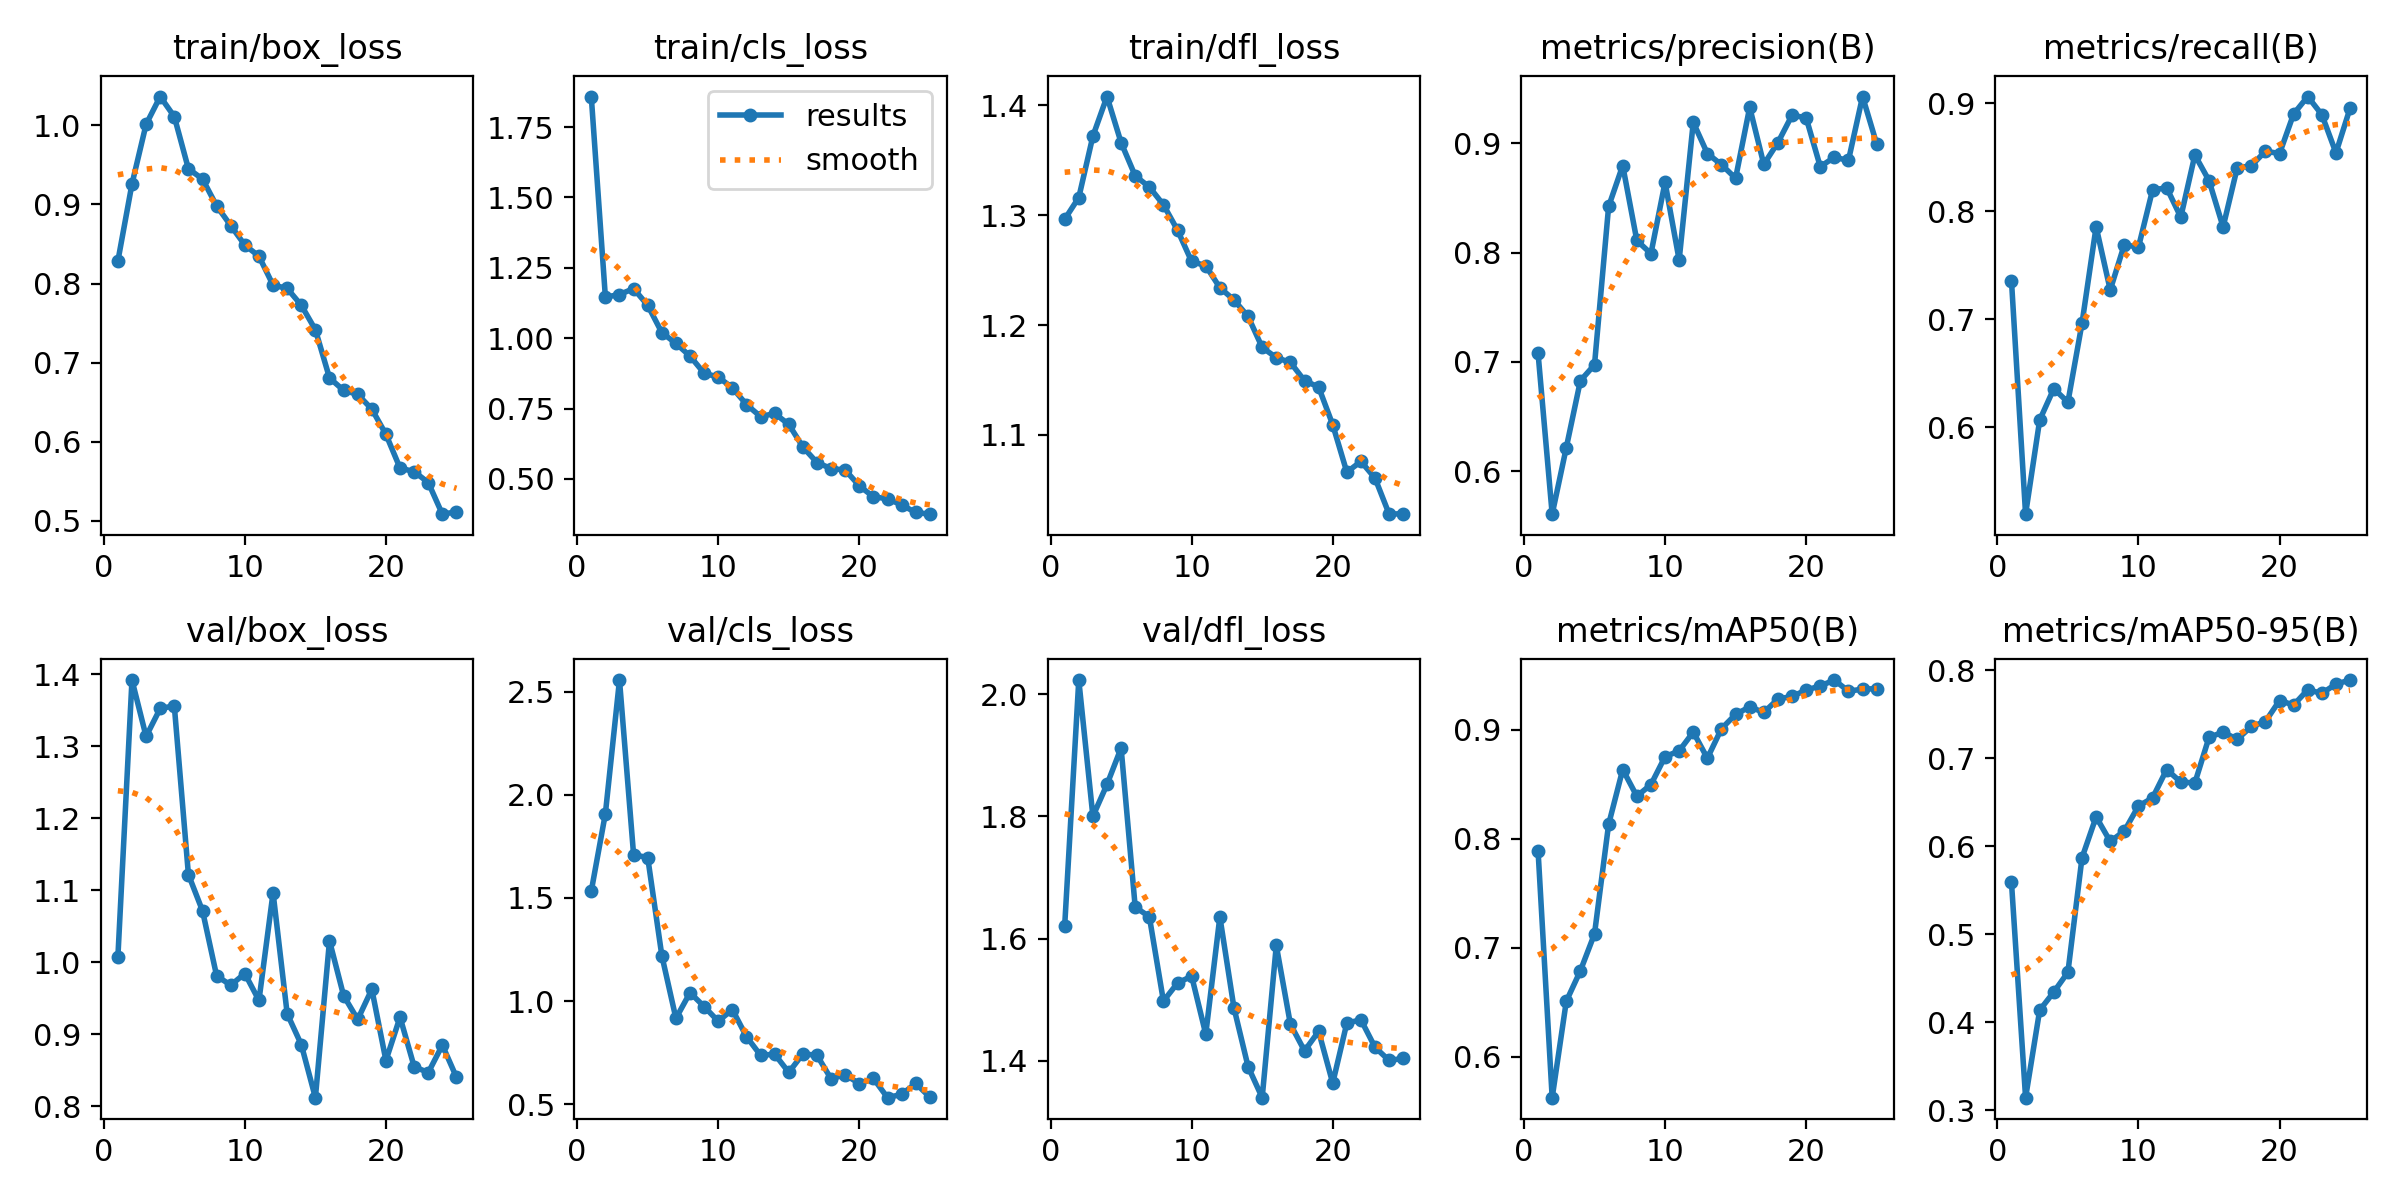

In [17]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

/content


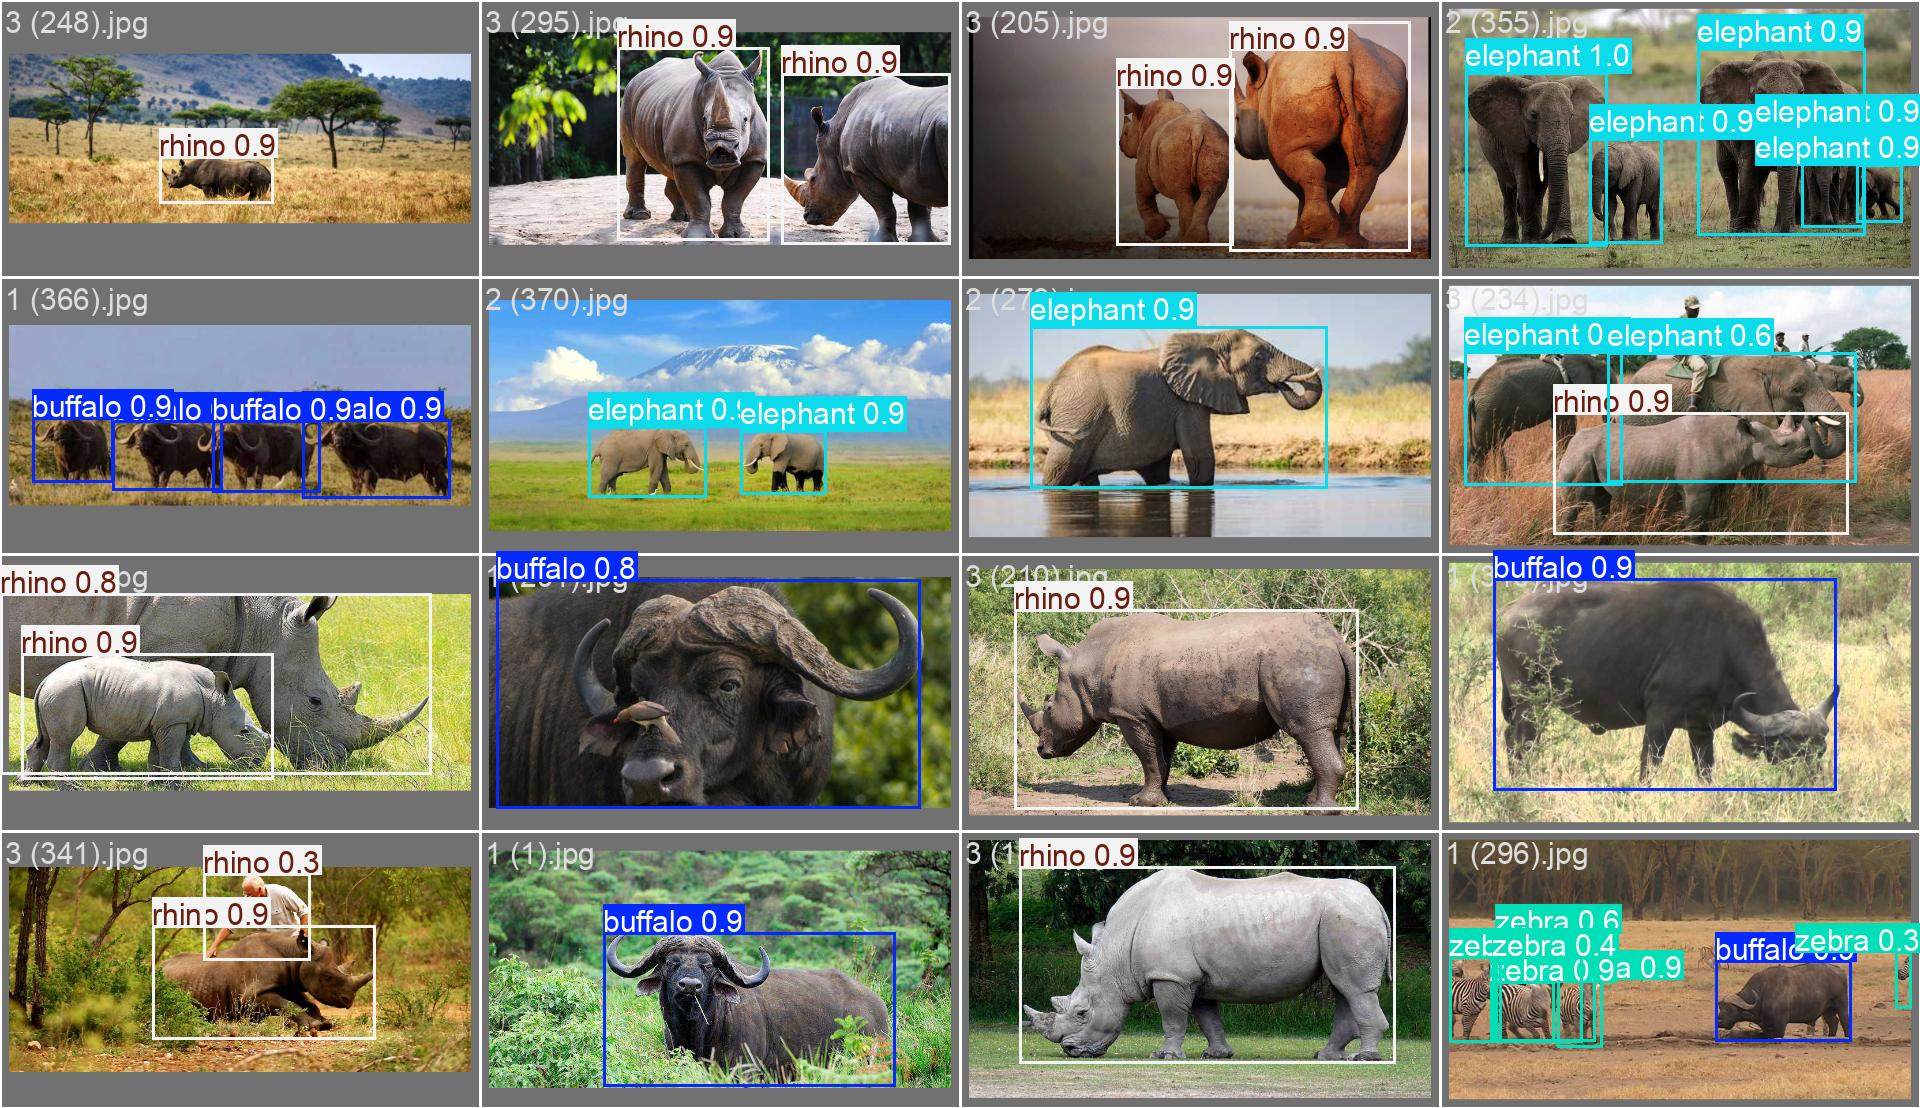

In [18]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [19]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 955, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/yolo/model.py", line 76, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 144, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 283, in _load
    self.model, self.ckpt = load_checkpoint(weights)
                            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/nn/tasks.py", line 1461, in load_checkpoint
    ckpt, weight = torch_safe_load(weight)  # load ckpt
                   

## Inference with Custom Model

In [20]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 955, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/yolo/model.py", line 76, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 144, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 283, in _load
    self.model, self.ckpt = load_checkpoint(weights)
                            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/nn/tasks.py", line 1461, in load_checkpoint
    ckpt, weight = torch_safe_load(weight)  # load ckpt
                   

**NOTE:** Let's take a look at few results.

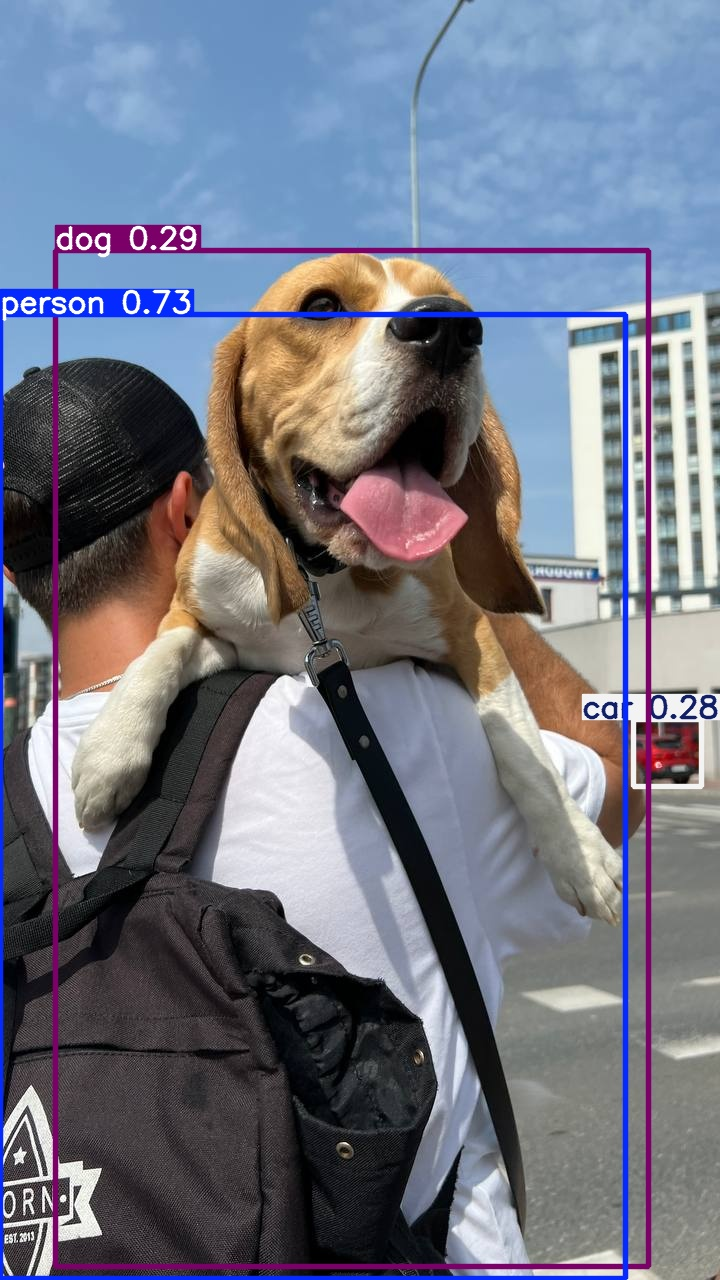

In [21]:
import glob
from IPython.display import Image, display

# Define the base path where the folders are located
base_path = '/content/runs/detect/'

# List all directories that start with 'predict' in the base path
subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

# Find the latest folder by modification time
latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:3]

# Display each image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv8 weights.

To upload model weights, add the following code to the “Inference with Custom Model” section in the aforementioned notebook:

In [22]:
####comment
#project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train/")

Follow the links above to check if the upload succeeded. It may take a couple of minutes until the model is visible to the `roboflow` SDK.

In [23]:
# Run inference on your model on a persistent, auto-scaling, cloud API

# Load model
model = project.version(dataset.version).model
assert model, "Model deployment is still loading"

# Choose a random test image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

NameError: name 'project' is not defined

In [24]:
##########################################
# --- Remplacement "cloud API Roboflow inference" : inférence LOCALE YOLOv8 ---

import os, random, glob
from ultralytics import YOLO

HOME = "/content"  # ou ta variable HOME si déjà définie

# 1) Trouver le dernier run (train, train2, ...)
runs = sorted(glob.glob(f"{HOME}/runs/detect/train*"), key=os.path.getmtime)
assert runs, "Aucun run trouvé. Lance d'abord model.train(...)"
run_dir = runs[-1]

# 2) Charger le meilleur modèle entraîné
best_pt = os.path.join(run_dir, "weights", "best.pt")
assert os.path.exists(best_pt), f"best.pt introuvable: {best_pt}"
model = YOLO(best_pt)

print("Run:", run_dir)
print("Model:", best_pt)

# 3) Choisir une image test aléatoire (structure YOLO standard)
test_images_dir = os.path.join(dataset.location, "images", "test")
assert os.path.isdir(test_images_dir), f"Dossier test images introuvable: {test_images_dir}"

random_test_image = random.choice([f for f in os.listdir(test_images_dir)
                                  if f.lower().endswith((".jpg", ".jpeg", ".png"))])
img_path = os.path.join(test_images_dir, random_test_image)
print("Running inference on:", img_path)

# 4) Prédire
results = model.predict(source=img_path, conf=0.40, iou=0.30)  # conf=0.40 ~ confidence=40%
results


Run: /content/runs/detect/train2
Model: /content/runs/detect/train2/weights/best.pt
Running inference on: /content/datasets/african-wildlife/images/test/2 (95).jpg

image 1/1 /content/datasets/african-wildlife/images/test/2 (95).jpg: 608x800 2 elephants, 47.6ms
Speed: 4.5ms preprocess, 47.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 800)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'buffalo', 1: 'elephant', 2: 'rhino', 3: 'zebra'}
 obb: None
 orig_img: array([[[207, 187, 169],
         [207, 187, 169],
         [207, 187, 169],
         ...,
         [102, 118, 125],
         [101, 117, 124],
         [ 43,  59,  66]],
 
        [[207, 187, 169],
         [207, 187, 169],
         [207, 187, 169],
         ...,
         [ 22,  40,  47],
         [ 75,  93, 100],
         [131, 149, 156]],
 
        [[207, 187, 169],
         [207, 187, 169],
         [207, 187, 169],
         ...,
         [ 26,  45,  52],
         [ 65,  84,  91],
         [163, 182, 189]],
 
        ...,
 
        [[158, 202, 225],
         [140, 184, 207],
         [149, 193, 216],
         ...,
         [161, 207, 225],
         [149, 195, 213],
         [104, 150, 168]],
 
        [[164, 208, 232],
         [148, 192, 216],
         [149, 193

# Deploy Your Model to the Edge

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device. You can deploy applications using the [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) or the pip package.

For example, to install Inference on a device with an NVIDIA GPU, we can use:

```
docker pull roboflow/roboflow-inference-server-gpu
```

Then we can run inference via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_thresh,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Also, set the URL of an image on which you want to run inference. This can be a local file.

_To use your YOLOv5 model commercially with Inference, you will need a Roboflow Enterprise license, through which you gain a pass-through license for using YOLOv5. An enterprise license also grants you access to features like advanced device management, multi-model containers, auto-batch inference, and more._

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.